# SARAO South Africa Provincial Epidemiological Model for COVID-19

This report summarises the results of an epidemiological model to estimate the near-term upper and lower bounds for total demand for hospitalization per province in South Africa due to COVID-19, to aid with production and logistics planning for the National Ventilator Project executed by SARAO.

In our [National Model](https://docs.google.com/document/d/1WBri6wTXfwqwz4K18Yvt2vRan-ydz18RwgGZJLJHuLg) work, we provide long-range (1-year) national forecasts by varying $R_t$ over plausible values intended to capture both goverment social interventions and heterogenous social compliance, within a still-unknown epidemiological landscape. 

Here, we instead use the near-past to predict the near-future: for each independent provincial model, we fit an exponential function to the previous 14 days of case data, and run 1000 scenarios, where the value of $R_t$ is allowed to vary within the standard deviation of this fit. Importantly, model are instantiated with current _reported_ data, and thus predict future reported parameters. Ensembles are reported with 68 percentile confidence intervals, as well as histograms through the ensembles at a 30-day horizon. 

Our models have several limitations. We rely on data from [https://github.com/dsfsi/covid19za](https://github.com/dsfsi/covid19za). We assume no inter-provincial mixing. We do not model heterogenous infectivity, such as 'superspreader' scenario effects, unknown community immunity, etc. These are short-term models: long-term predictions should take in to account government interventions and community compliance on the effective values $R_t(t)$ can assume.

__

*Disclaimer: the models described here are intended for general information purposes only. The authors accept no liability or responsibility for the use of the information in this document and provide no warranty regarding any results, data or code herein.*


In [1]:
%%capture init_output
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

from scipy.integrate import solve_ivp
from scipy import stats

from scipy import optimize
from scipy.optimize import brentq, newton

!pip install wget;
!pip install lmfit;

import wget
import ssl
from lmfit import minimize, Parameters, report_fit 

from IPython.display import Markdown, display
import matplotlib.colors as mcolors

from matplotlib.ticker import ScalarFormatter

colors_inv = {}#{v: k for k, v in colors.TABLEAU_COLORS.items()}
for idx, color in enumerate(mcolors.TABLEAU_COLORS):
  colors_inv[idx] = color



In [2]:
model_days = 30
N_RUNS = 1000

yesterday = date.today() - timedelta(days=1)
start_date = str(yesterday)

# ICU facilities becoming overwhelmed
ICU_OVERWHELM = False#True #False
# R_t being modified due to number of deaths:
DEATH_REACTIVE_R_T = False#True #False

In [3]:
# Susceptible
def dS_dt(S, I, R_t, t_inf):
    return -(R_t / t_inf) * I * S

# Exposed
def dE_dt(S, E, I, R_t, t_inf, t_inc):
    return (R_t / t_inf) * I * S - (E / t_inc)

# Infected
def dI_dt(I, E, t_inc, t_inf):
    return (E / t_inc) - (I / t_inf)

# Hospitalized 
def dH_dt(I, C, H, t_inf, t_hosp, t_crit, frac_mild_total, frac_fatal):
    return ((1 - frac_mild_total) * (I / t_inf)) + ((1 - frac_fatal) * C / t_crit) - (H / t_hosp)

# Critical
def dC_dt(H, C, t_hosp, t_crit, frac_crit):
    return (frac_crit * H / t_hosp) - (C/t_crit)
    # return (frac_crit * H / t_hosp) - (1-frac_fatal)*(C/t_crit) - frac_fatal*(C/t_crit)
    # i.e.  = (term gained from Hospitalised) - (term lost to Hospitalised) - (term lost to Deaths)
    #       = (term gained from H) - (terms lost to both H and D)

# Recovered
def dR_dt(I, H, t_inf, t_hosp, frac_mild_total, frac_crit):
    return (frac_mild_total * I / t_inf) + (1 - frac_crit) * (H / t_hosp)

# Deaths
def dD_dt(C, t_crit, frac_fatal):
    return frac_fatal * (C/t_crit)

# this function is a saturating look-up table
def find_idx_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx # array[idx], idx

def SEIR_HCD_model(t, y, R_t, t_inc=2.9, t_inf=6.1, t_hosp=4, t_crit=10, frac_mild_total=0.96, frac_crit=0.2, frac_fatal=0.2):
    """
    :param t: Time step for solve_ivp
    :param y: Previous solution or initial values
    :param R_t: Time-varying reproductive number
    :param t_inc: Average incubation period. 
    :param t_inf: Average infectious period. 
    :param t_hosp: Average time a patient is in hospital before either recovering or becoming critical.
    :param t_crit: Average time a patient is in a critical state (either recovers or dies).
    :param frac_mild_total: Fraction of infections that are asymptomatic or mild.      
    :param frac_crit: Fraction of severe cases that turn critical.                      
    :param frac_fatal: Fraction of critical cases that are fatal.                   
    :return:
    """
    
    # Evaluate R_t if it is a function, otherwise use it as is
    if callable(R_t):
        reprod = R_t(t)
    else:
        reprod = R_t

    S, E, I, R, H, C, D = y


    # Account for ICU overload by modifying the fatality ratio
    if ICU_OVERWHELM:
      ICU_CAPACITY = 4000/N # 
      if C > ICU_CAPACITY:
        frac_fatal = (ICU_CAPACITY/C)*frac_fatal + ((C - ICU_CAPACITY)/C)*np.minimum(0.95, np.random.normal(0.75, 0.10))
        #frac_fatal =  (patients needing ICU who can get it)*(regular fatality rate) + (patients needing ICU who can't get it)*(higher fatality rate)
    
    if DEATH_REACTIVE_R_T:
      # account for effect of increased deaths in a society: 
      #   i. extra lockdown by goverment in response to more deaths 
      #   ii. greater compliance with social distancing measures
      # by having a cap/limit for R_t, depending on the number of deaths
      
      dn = np.linspace(1e+02, 5e+04, 100)
      rn = np.linspace(3, 1.2, 100)
      rtcap = rn[find_idx_nearest(dn, D*N)] 
      reprod = np.minimum(rtcap, reprod)

    S_out = dS_dt(S, I, reprod, t_inf)
    E_out = dE_dt(S, E, I, reprod, t_inf, t_inc)
    I_out = dI_dt(I, E, t_inc, t_inf)
    R_out = dR_dt(I, H, t_inf, t_hosp, frac_mild_total, frac_crit)
    H_out = dH_dt(I, C, H, t_inf, t_hosp, t_crit, frac_mild_total, frac_fatal)
    C_out = dC_dt(H, C, t_hosp, t_crit, frac_crit)
    D_out = dD_dt(C, t_crit, frac_fatal)
    return [S_out, E_out, I_out, R_out, H_out, C_out, D_out]

In [32]:
def plot_ensemble(N, scenarios, alpha_val, title='SARAO SEIR-HCD Model'):
    # set up the axes, titles, styles, etc
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,12))
    fig.suptitle(title, fontsize=16)
    ax1.set_title("Individuals in Critical State")
    ax2.set_title("Fatalities")
    ax3.set_title("Individuals in Hospital")
    ax4.set_title(("Cumulative Total Cases"))
    #ax4.set_title(("Current Total Cases"))
    
    ax3.set_xlabel("Days", fontsize=15);
    ax4.set_xlabel("Days", fontsize=15);
    
    # set uniform characteristics for axes
    for idx, axis in enumerate([ax1, ax2, ax3, ax4]):
        axis.set_ylim(ymin=6, ymax=N*1.2)
        axis.set_xlim(0, model_days)
        axis.set_yscale('log')
        axis.tick_params(axis='y', labelsize=15);
        axis.tick_params(axis='x', labelsize=15);
        axis.hlines([1e+03, 1e+04, 1e+05, 1e+06], xmin=0, xmax=model_days, linestyles='dotted', alpha = 0.6);
        axis.yaxis.set_major_formatter(ScalarFormatter())
    
    # loop over each scenario in the ensemble and plot to the axes
    median_death_list = []
    median_hosp_list = []
    median_critical_list = []
    median_cases_list = []

    #print(len(scenarios), N, N_RUNS)

    for idx, solution in enumerate(scenarios):
        sus, exp, inf, rec, hosp, crit, death = solution.y
        cases = (inf + rec + hosp + crit + death)
        ax1.plot(crit*N, 'tab:orange', label='Critical', alpha=alpha_val);
        ax2.plot(death*N, 'red', label='Fatalities', alpha=alpha_val);
        ax3.plot(hosp*N, 'dodgerblue', label='Hospitalised', alpha=alpha_val);
        ax4.plot(cases*N, 'tab:blue', label='All cases', alpha=alpha_val);
        
        median_death_list.append(scenarios[idx].y[6])
        median_hosp_list.append(scenarios[idx].y[4])
        median_critical_list.append(scenarios[idx].y[5])
        median_cases_list.append(scenarios[idx].y[2]+scenarios[idx].y[3]+scenarios[idx].y[4]+scenarios[idx].y[5]++scenarios[idx].y[6])
    
    median_curve_deaths = np.median(median_death_list,axis = 0)
    median_curve_hosp = np.median(median_hosp_list,axis = 0)
    median_curve_critical = np.median(median_critical_list,axis = 0)
    median_curve_cases = np.median(median_cases_list,axis = 0)

    #ax1.plot(median_curve_critical*N, color = 'white', linewidth = '2') #, label='Fatalities', alpha=alpha_val);
    ax2.plot(median_curve_deaths*N, color = 'magenta', linewidth = '2') #, label='Fatalities', alpha=alpha_val);
    #ax3.plot(median_curve_hosp*N, color = 'white', linewidth = '2') #, label='Fatalities', alpha=alpha_val);
    ax4.plot(median_curve_cases*N, color = 'magenta', linewidth = '2') #, label='Fatalities', alpha=alpha_val);


    #plot measured cases and deaths from Worldometer
    #dates = np.array(["Feb 15","Feb 16","Feb 17","Feb 18","Feb 19","Feb 20","Feb 21","Feb 22","Feb 23","Feb 24","Feb 25","Feb 26","Feb 27","Feb 28","Feb 29","Mar 01","Mar 02","Mar 03","Mar 04","Mar 05","Mar 06","Mar 07","Mar 08","Mar 09","Mar 10","Mar 11","Mar 12","Mar 13","Mar 14","Mar 15","Mar 16","Mar 17","Mar 18","Mar 19","Mar 20","Mar 21","Mar 22","Mar 23","Mar 24","Mar 25","Mar 26","Mar 27","Mar 28","Mar 29","Mar 30","Mar 31","Apr 01","Apr 02","Apr 03","Apr 04","Apr 05","Apr 06","Apr 07","Apr 08","Apr 09","Apr 10","Apr 11","Apr 12","Apr 13","Apr 14","Apr 15","Apr 16","Apr 17","Apr 18","Apr 19","Apr 20","Apr 21","Apr 22","Apr 23","Apr 24","Apr 25","Apr 26","Apr 27","Apr 28","Apr 29","Apr 30","May 01","May 02","May 03","May 04","May 05","May 06","May 07","May 08","May 09","May 10","May 11","May 12","May 13","May 14","May 15","May 16","May 17","May 18","May 19","May 20","May 21","May 22","May 23","May 24","May 25","May 26","May 27","May 28","May 29","May 30","May 31","Jun 01","Jun 02","Jun 03","Jun 04","Jun 05","Jun 06"])
    recorded_deaths = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,5,5,5,9,9,11 ,12,13,18,18,24,25,25,27,27,34,48,50,52,54,58,58,65,75,79,86,87,90,93,103,103,116,123,131,138,148,153,161,178,186,194,206,206,219,238,247,261,264,286,312,339,369,397,407,429,481,524,552,577,611,643,683,705,755,792,848,908,952,998,1080,1162,1210,1284,1354,1423,1480,1568,1625,1674,1737,1831,1877,1930,1991,2102,2205,2292,2340,2413,2456,2529,2657,2749,2844,2952,3026,3199,3310,3502,3602,3720,3860,3971,4079,4172,4346,4453,4669,4804,4948,5033,5173,5368,5940,6093,6343,6655])
    ax2.semilogy(recorded_deaths[46:], color = 'k', linewidth = '3')  # Plot from 1 April

In [5]:
def plot_medians(p_scenarios, Recent_prov_Rt, alpha_val = 0.8, title='SARAO SEIR-HCD Provincial model'):
    # set up the axes, titles, styles, etc
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,12))

    for idx, axis in enumerate([ax1, ax2, ax3, ax4]):
      #axis.set_yscale('log')
      #axis.set_ylim(ymin=1, ymax=N*1.2)
      #axis.hlines([1e+03, 1e+04, 1e+05, 1e+06], xmin=0, xmax=model_days, linestyles='dotted', alpha = 0.6);
      axis.set_xlim(0, model_days)
      axis.tick_params(axis='y', labelsize=15);
      axis.tick_params(axis='x', labelsize=15);
      axis.set_xlabel("days since "+ start_date)
      #axis.yaxis.set_major_formatter(ScalarFormatter())
        
    
    ax1.set_title("Critical", fontsize=15)
    ax2.set_title("Deaths", fontsize=15)
    ax3.set_title("Hospitalised", fontsize=15)
    ax4.set_title("All Cases", fontsize=15)
    fig.suptitle(title + " predictions from " + start_date , fontsize=16) #+ " (median ensemble values at 30 and 60 days respectively in parenthesis, 1-sigma confidence interval)", fontsize=14)

    for idx, (scenarios, prov_long) in enumerate(p_scenarios):
      #color = np.random.rand(3,)
      color = colors_inv[idx]
      ## Pull out population for specified province
      prov_pop_index = SA_P_Pop[SA_P_Pop['Province']==prov_long].index.item()
      prov_pop = SA_P_Pop.Pop[prov_pop_index]
      # loop over each scenario in the ensemble and plot to the axes
      death_list = []
      hosp_list = []
      critical_list = []
      cases_list = []

      for idx, solution in enumerate(scenarios):
        sus, exp, inf, rec, hosp, crit, death = solution.y
        cases = (inf + rec + hosp + crit + death)
        
        #ax1.plot(crit*N, 'tab:orange', label='Critical', alpha=alpha_val);
        #ax2.plot(death*N, 'red', label='Fatalities', alpha=alpha_val);
        #ax3.plot(hosp*N, 'dodgerblue', label='Hospitalised', alpha=alpha_val);
        #ax4.plot(cases*N, 'tab:blue', label='All cases', alpha=alpha_val);

        death_list.append(scenarios[idx].y[6])
        hosp_list.append(scenarios[idx].y[4])
        critical_list.append(scenarios[idx].y[5])
        cases_list.append(scenarios[idx].y[2]+scenarios[idx].y[3]+scenarios[idx].y[4]+scenarios[idx].y[5]++scenarios[idx].y[6])
    
      #median_curve_critical = np.median(critical_list,axis = 0)
      median_curve_critical = np.percentile(critical_list, 50, axis = 0)
      percentile_84_critical = np.percentile(critical_list, 84, axis = 0)
      percentile_16_critical = np.percentile(critical_list, 16, axis = 0)

      median_curve_death = np.median(death_list,axis = 0)
      percentile_84_death = np.percentile(death_list, 84, axis = 0)
      percentile_16_death = np.percentile(death_list, 16, axis = 0)

      median_curve_hosp = np.median(hosp_list,axis = 0)
      percentile_84_hosp = np.percentile(hosp_list, 84, axis = 0)
      percentile_16_hosp = np.percentile(hosp_list, 16, axis = 0)

      median_curve_cases = np.median(cases_list,axis = 0)
      percentile_84_cases = np.percentile(cases_list, 84, axis = 0)
      percentile_16_cases = np.percentile(cases_list, 16, axis = 0)


      lab=prov_dict_inv[prov_long] + " (" + str(int(median_curve_critical[14]*prov_pop)) + ", " + str(int(median_curve_critical[29]*prov_pop)) + ")"
      ax1.semilogy(median_curve_critical*prov_pop, linewidth = '2', label=lab, alpha=alpha_val, color = color);
      ax1.fill_between(range(model_days), percentile_84_critical*prov_pop, percentile_16_critical*prov_pop, color = color, alpha=alpha_val/20);
      ax1.plot(percentile_84_critical*prov_pop, linewidth = '2', alpha=alpha_val/3, color = color, linestyle='--');
      ax1.plot(percentile_16_critical*prov_pop, linewidth = '2', alpha=alpha_val/3, color = color, linestyle='--');
      ax1.yaxis.set_major_formatter(ScalarFormatter())
      ax1.legend()

      lab=prov_dict_inv[prov_long] + " (" + str(int(median_curve_death[14]*prov_pop)) + ", " + str(int(median_curve_death[29]*prov_pop)) + ")"
      ax2.semilogy(median_curve_death*prov_pop, linewidth = '2', label=lab, alpha=alpha_val, color = color)
      ax2.fill_between(range(model_days), percentile_84_death*prov_pop, percentile_16_death*prov_pop, color = color, alpha=alpha_val/20);
      ax2.plot(percentile_84_death*prov_pop, linewidth = '2', alpha=alpha_val/3, color = color, linestyle='--');
      ax2.plot(percentile_16_death*prov_pop, linewidth = '2', alpha=alpha_val/3, color = color, linestyle='--');
      ax2.yaxis.set_major_formatter(ScalarFormatter())
      ax2.legend()

      lab=prov_dict_inv[prov_long] + " (" + str(int(median_curve_hosp[14]*prov_pop)) + ", " + str(int(median_curve_hosp[29]*prov_pop)) + ")"
      ax3.semilogy(median_curve_hosp*prov_pop, linewidth = '2', label=lab, alpha=alpha_val, color = color)
      ax3.fill_between(range(model_days), percentile_84_hosp*prov_pop, percentile_16_hosp*prov_pop, color = color, alpha=alpha_val/20);
      ax3.plot(percentile_84_hosp*prov_pop, linewidth = '2', alpha=alpha_val/3, color = color, linestyle='--');
      ax3.plot(percentile_16_hosp*prov_pop, linewidth = '2', alpha=alpha_val/3, color = color, linestyle='--');
      ax3.yaxis.set_major_formatter(ScalarFormatter())
      ax3.legend()

      lab = prov_dict_inv[prov_long] + " ($R_t$: " + "{:.2f}".format(Recent_prov_Rt[prov_short_l[prov_long_l.index(prov_long)]][0]) +', $\sigma$: ' + "{:.2f}".format(Recent_prov_Rt[prov_short_l[prov_long_l.index(prov_long)]][1]) +")"
      #Recent_prov_Rt[prov_short_l[prov_long_l.index('Western Cape')]][0]
      ax4.semilogy(median_curve_cases*prov_pop, linewidth = '2', label=lab, alpha=alpha_val, color = color)
      #ax4.fill_between(range(model_days), percentile_84_cases*prov_pop, percentile_16_cases*prov_pop, color = color, alpha=alpha_val/20);
      #ax4.plot(percentile_84_cases*prov_pop, linewidth = '2', alpha=alpha_val/3, color = color, linestyle='--');
      #ax4.plot(percentile_16_cases*prov_pop, linewidth = '2', alpha=alpha_val/3, color = color, linestyle='--');
      ax4.legend()
      

      #print('|', prov_long, '|', prov_pop, '|',  "{:.2f}".format(Recent_prov_Rt[prov_short_l[p_idx]][0]), '|', int(median_curve_hosp[29]*prov_pop), '|', int(median_curve_hosp[59]*prov_pop), '|', int(median_curve_death[29]*prov_pop), '|', int(median_curve_death[59]*prov_pop), '|')



In [6]:
#delete after testing
#print("Median ensemble values at 30 and 60 days respectively in parenthesis, 1-sigma confidence interval")
#plot_medians(p_scenarios, Recent_prov_Rt)

#colors.XKCD_COLORS

#colors_inv

#prov_dict_inv['E']

In [7]:
def get_SA_province(ToUpdateSAProvince):
    '''
    Ussl._create_default_https_context = ssl._create_unverified_contextsage:
    
        get_SA_province('y') or get_SA_province('n')
    
    This function will get the SA provincial confirmed and cases as function of date
    It also has the total that should agree with the reported worldodometer confirmed cases
    
    Input:
        Take a y or n - whether to update the dataset or not
    
    Output:
        Returns the SA province confirmed dataframe
    '''
    

    if ToUpdateSAProvince.lower() =='y':
        
        #print("updating data")
        ConfirmedURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
        SAProvinConfirmed = pd.read_csv(wget.download(ConfirmedURL))
        
        DeathURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv"
        SAProvinDead = pd.read_csv(wget.download(DeathURL))
        
        RecoveredURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv"
        SAProvinRecover = pd.read_csv(wget.download(RecoveredURL))
        
        #included population
        ConfirmedPopURL = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
        SAProvinPop = pd.read_csv(wget.download(ConfirmedPopURL),header=None)
        SAProvinPop.columns = ['Province', 'Pop']
        
    else:
        print("Reading local file... Please check data is uptodate")
        SAProvinConfirmed  = pd.read_csv("covid19za_provincial_cumulative_timeline_confirmed.csv")
        SAProvinDead = pd.read_csv("covid19za_provincial_cumulative_timeline_deaths.csv")
        SAProvinRecover = pd.read_csv("covid19za_provincial_cumulative_timeline_recoveries.csv")
        #print(f"Note: File was last updated on {SAProvinConfirmed['date'].values[-1]}")
    #
    # Drop the unwanted column
    #
    if 'YYYYMMDD' in SAProvinConfirmed.columns:
        SAProvinConfirmed.drop(columns='YYYYMMDD', inplace = True)
        SAProvinDead.drop(columns='YYYYMMDD', inplace = True)
        SAProvinRecover.drop(columns='YYYYMMDD', inplace = True)
    #
    # Drop the source of information
    #
    if 'source' in SAProvinConfirmed.columns:
        SAProvinConfirmed.drop(columns='source', inplace = True)
        SAProvinDead.drop(columns='source', inplace = True)
        SAProvinRecover.drop(columns='source', inplace = True)


    #reconfigure date values
    SAProvinConfirmed["date"] = pd.to_datetime(SAProvinConfirmed.date, format='%d-%m-%Y') 
    SAProvinDead["date"] = pd.to_datetime(SAProvinDead.date, format='%d-%m-%Y')
    SAProvinRecover["date"] = pd.to_datetime(SAProvinRecover.date, format='%d-%m-%Y')

    #add in missing dates and values - Sam added 
    #method
    #r = pd.date_range(start=df.dt.min(), end=df.dt.max())
    #df = df.set_index('dt').reindex(r).fillna(method = 'ffill').rename_axis('dt').reset_index()
    
    #specify start and end date for dataframes - Sam added
    start_for_all = '2020-04-01'
    extended_dates = pd.date_range(start=start_for_all, end=SAProvinConfirmed.date.max()) #using the same so that end dates are consistent
    

    #expand out datasets to include missing dates and fill empty cells with previous values - - Sam added
    SAProvinConfirmed = SAProvinConfirmed.set_index('date').reindex(extended_dates).fillna(method = 'ffill').rename_axis('date').reset_index()
    SAProvinDead = SAProvinDead.set_index('date').reindex(extended_dates).fillna(method = 'ffill').rename_axis('date').reset_index()
    SAProvinRecover = SAProvinRecover.set_index('date').reindex(extended_dates).fillna(method = 'ffill').rename_axis('date').reset_index()


    #ensure no null values at the begining where no data existed yet to enable a previous value copy - - Sam added
    SAProvinConfirmed = SAProvinConfirmed.fillna(0.0)
    SAProvinDead = SAProvinDead.fillna(0.0)
    SAProvinRecover = SAProvinRecover.fillna(0.0)

    #
    # Make the date the index
    #
    
    SAProvinConfirmed.index = SAProvinConfirmed["date"]
    SAProvinDead.index = SAProvinDead["date"]
    SAProvinRecover.index = SAProvinRecover["date"]
    
    #
    # Deleting the date column now
    #
    SAProvinConfirmed.drop(columns='date', inplace = True)
    SAProvinDead.drop(columns='date', inplace = True)
    SAProvinRecover.drop(columns='date', inplace = True)
    #
    # Renaming the Total column to Confirmed
    #
    SAProvinConfirmed = SAProvinConfirmed.rename(columns={'total': 'Confirmed'})
    SAProvinDead = SAProvinDead.rename(columns={'total': 'Dead'})
    SAProvinRecover = SAProvinRecover.rename(columns={'total': 'Recovered'})
    #
    #
    #
    return(SAProvinConfirmed, SAProvinDead, SAProvinRecover, SAProvinPop)


In [8]:
#
# Reference: Felix via Nadeem 02 June 2020
#
def get_Rt_lm(DFSeries):
    params = Parameters()
    params.add('a', value=0.)
    params.add('b', value=0.)
    def get_residuals(params, x, data):
      a=params['a'].value
      b=params['b'].value
      model = a * np.exp(b*x)
      return data - model

    x = np.arange(len(DFSeries))
    data = list(DFSeries.values)
    out = minimize(get_residuals,params, args = (x,data))
    a = out.params['a'].value
    b = out.params['b'].value
    sigma_b = out.params['b'].stderr
    
    T_d = np.log(2)/b 
    tau = 7.0 # 9.3 #8.15 https://www.nature.com/articles/s41591-020-0869-5 
    sigma_Rt = (np.exp(b*tau)) * (np.sinh(tau*sigma_b)) #obtaining error for Rt based on error in b
    Rt = np.mean(np.exp(b*tau))
    
    return (Rt , sigma_Rt)

In [9]:
# (from Felix https://github.com/sillsphelyx/Rt_update/blob/master/RtUpdate.py)

def get_K(DFSeries):
    
    ''' This function is for fitting the exponential function to 
    series of confirmed cases in order to estimate the exponential
    growth rate K '''
 
    import numpy as np
    from lmfit import minimize, Parameters, report_fit # added by [NO]
    
    params = Parameters()
    params.add('a', value=0.)
    params.add('b', value=0.)
    def get_residuals(params, x, data):
        a=params['a'].value
        b=params['b'].value
        model = a * np.exp(b*x)
        return data - model
    x = np.arange(len(DFSeries))
    data = list(DFSeries.values)
    out = minimize(get_residuals,params, args = (x,data))
    a = out.params['a'].value
    b = out.params['b'].value
    sigma_b = out.params['b'].stderr
    
    #a = LogisticFit[0][0]
    #b = LogisticFit[0][1] # This is also known as K from description in Wikipedia
    
    # The dooubling rate is given by T_d
    
    T_d = np.log(2)/b
        
    return (b) 

def Update_Rt(DF,Days_of_int=14):
    '''This function will calculate the value of Rt for a DataFrame with k columns and atleast 2 rows.
    In order to calculate R0 we can adapt this 
    https://en.wikipedia.org/wiki/Basic_reproduction_number#Estimation_methods
    Reminder: Rt = R0 when no intervention has been applied and there is mixing
    
    usage get_Rt(pandas DataFrame)
    
    Input:
        Take in a pandas DataFrame with columns representing series of confirmed cases or deaths and the number of most           recent days for which you want to estimate Rt (default=14).
    Output:
        Return DataFrame with respective median Rt values and their 95% CI's for each respective column's Rt                     distributions generated by way of sampling the infectiousness time from a gaussian with mean 9.3 and                     standard deviation 1.15
    '''
    import numpy as np
    import pandas as pd
    itr = 1000
    Rt_dict = dict()
    for col in DF.columns:
        K = get_K(DF.tail(Days_of_int)[col])
        R_t = np.zeros(itr)
        for i in range(itr):
            tau = np.random.normal(8.15, 1.15) # 9.3 #8.15 #7.0 https://www.nature.com/articles/s41591-020-0869-5 
            R_t[i] = np.exp(K*tau)
        #Rt_dict.update({col:[np.percentile(R_t, 50),(np.percentile(R_t, 2.5),np.percentile(R_t, 97.5))]}) RPA changed to below:
        Rt_dict.update({col:[np.percentile(R_t, 50),(np.percentile(R_t, 84) - np.percentile(R_t, 16))]})
    Rt_est_df = pd.DataFrame.from_dict(Rt_dict, orient='index', columns=['Median_Rt_estimate', '68%_CI'])
    #return(Rt_est_df) RPA changed to below: (i.e. return dictionary rather than DataFrame)
    return Rt_dict

In [10]:
def time_varying_reproduction(t):
  if t < t_1:
    # throw warning that default value of R_0 is being used
    warnings.warn("Using lower default R_0 in time-varying_reproduction function") 
    return R_0
  elif t >= t_1 and t < t_2:
    return R_t_1
  elif t >= t_2:
    return R_t_2
  else:
    warnings.warn("Using upper default R_0 in time-varying_reproduction function")
    return R_0

# Provincial Ensembles

In [11]:
prov_long_l = ['Gauteng', 'KwaZulu-Natal', 'Western Cape', 'Eastern Cape', 'Limpopo', 'Mpumalanga', 'Northwest', 'Free State', 'Northern Cape']
prov_short_l = ['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']#, 'UNKNOWN']

prov_long_l.sort()
prov_short_l.sort()
prov_dict = {}
prov_dict_inv = {}

for idx, prov in enumerate(prov_short_l):
  prov_dict[prov] = prov_long_l[idx]
  prov_dict_inv[prov_long_l[idx]] = prov

#print(prov_long_l, prov_short_l, 
#print(prov_dict)

In [12]:
SA_P_Con, SA_P_Dead, SA_P_Rec, SA_P_Pop = get_SA_province('y') #use 'y' if no local datasets stored

# rename Dead to Total Deaths, and drop the UNKNOWN col
for idx, SA_P in enumerate([SA_P_Con, SA_P_Dead, SA_P_Rec]):
  SA_P.rename(columns={'Dead':'Total Deaths'}, inplace=True)
  SA_P.rename(columns={'Confirmed':'Total Confirmed'}, inplace=True)
  SA_P.drop(columns={'UNKNOWN'}, inplace=True)

#Recent_prov_Rt = {i: get_Rt_lm(SA_P_Con.tail(14)[i]) for i in SA_P_Con.columns}
Recent_prov_Rt = Update_Rt(SA_P_Con.tail(14))

# Reported values on specified date - Sam added throughout this section to bring in selected province data

t_1 = 0
t_2 = 30

p_scenarios = []

for p_idx, prov_long in enumerate(prov_long_l):
    prov_pop_index = SA_P_Pop[SA_P_Pop['Province']==prov_long].index.item()
    ## Pull out population for specified province
    prov_pop = SA_P_Pop.Pop[prov_pop_index]
    ## get confirmed cases at date for province specified
    prov_con = SA_P_Con.loc[start_date, prov_short_l[p_idx]]
    ## get recovered cases at date for province specified
    prov_rec = SA_P_Rec.loc[start_date, prov_short_l[p_idx]]
    ## get deaths at date for province specified
    prov_dead = SA_P_Dead.loc[start_date, prov_short_l[p_idx]]
    
    N = prov_pop  # Population size
    n_total_cases = prov_con 
    n_recovered = prov_rec
    n_tested_active =  prov_con - prov_rec # total cases - recovered: 
    n_hosp = 0.1* n_tested_active #making an estimate - there is real data from here for WC https://corona-stats.mobi/en/ZA/westerncape.php
    n_crit = 0.3* n_hosp ##making an estimate - there is real data from here for WC https://corona-stats.mobi/en/ZA/westerncape.php
    n_dead = prov_dead
    
    
    scenarios = []
    
    for i in range(N_RUNS):
        R_t_1 = np.maximum(0.9, np.random.normal(Recent_prov_Rt[prov_short_l[p_idx]][0], Recent_prov_Rt[prov_short_l[p_idx]][1])) #, 0.15))
        R_t_2 = np.maximum(0.9, np.random.normal(Recent_prov_Rt[prov_short_l[p_idx]][0], 2*Recent_prov_Rt[prov_short_l[p_idx]][1])) #, 0.25))

        # Draw from epidemiological parameter distributions
        R_0 = np.maximum(1.0, np.random.normal(1.8, 0.15))
        t_incu = np.random.normal(5.1, 0.325) # average incubation period: "median incubation period was estimated to be 5.1 days (95% CI, 4.5 to 5.8 days) https://www.acpjournals.org/doi/10.7326/M20-0504
        t_infect = np.maximum(2, np.random.normal(9.3, 1.15)) #t_infect = np.maximum(3,np.random.normal(9.3, 1.15)) NB - changed to range over which density of infectiousness was 1%
        t_hosp = np.maximum(3, np.random.normal(10.4, 4)) # time in hospital before transitioning to either critical or recovered https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf
        t_crit = np.maximum(3, np.random.normal(10, 2)) # average time patient is critical before transition to recovered or dead    https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf

        frac_asymptomatic = np.minimum(0.96, np.random.normal(0.75, 0.15)) #5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
        frac_tested_mild = np.minimum(0.96, np.random.normal(0.85, 0.05)) # ratio of tested infections that are mild. [CCDC]
        frac_mild_total = 1-((1-frac_asymptomatic) * (1 - frac_tested_mild))
        
        frac_crit = np.maximum(0.17, np.random.normal(0.31, 0.07)) # fraction of severe cases that become critical: 33% died, 49% discharged, 17% continue receiveing care, 17% required ICU: 45% died, 31% discharged 
        frac_fatal = np.maximum(0.2, np.random.normal(0.56, 0.06))  # fraction of critical cases that result in death: https://www.medrxiv.org/content/10.1101/2020.04.23.20076042v1.full.pdf
        
        n_infected = n_tested_active * (1/(1-frac_asymptomatic))
        n_exposed = n_infected * 1.7 #(R_t^(time from infection to test)/t_inf ~ 2)*n_infected
        n_recovered = (n_total_cases - n_tested_active) * (1/(1-frac_asymptomatic))

        n_susceptible = (N - (n_exposed + n_infected + n_recovered + n_hosp + n_crit + n_dead))#/2 # model a 50% immune fraction
        
        # Set up state and solve IVP

        initial_state = [n_susceptible/N, n_exposed/N, n_infected/N, n_recovered/N, n_hosp/N, n_crit/N, n_dead/N] #S, E, I, R, H, C, D  
        
        args = (time_varying_reproduction, t_incu, t_infect, t_hosp, t_crit, frac_mild_total, frac_crit, frac_fatal)
        
        sol = solve_ivp(SEIR_HCD_model, [0, model_days], initial_state, args=args, t_eval=np.arange(model_days))
        
        scenarios.append(sol)

    #plot_ensemble(N, scenarios, 0.05, title = "SARAO: SEIR-HCD model - Intervention Scenario Ensemble")

    p_scenarios.append([scenarios, prov_long])
    
    #print(prov_long, prov_short_l[p_idx], ": ", Recent_prov_Rt[prov_short_l[p_idx]][0], prov_pop, n_total_cases, n_tested_active, n_recovered, n_hosp, n_crit, n_dead)

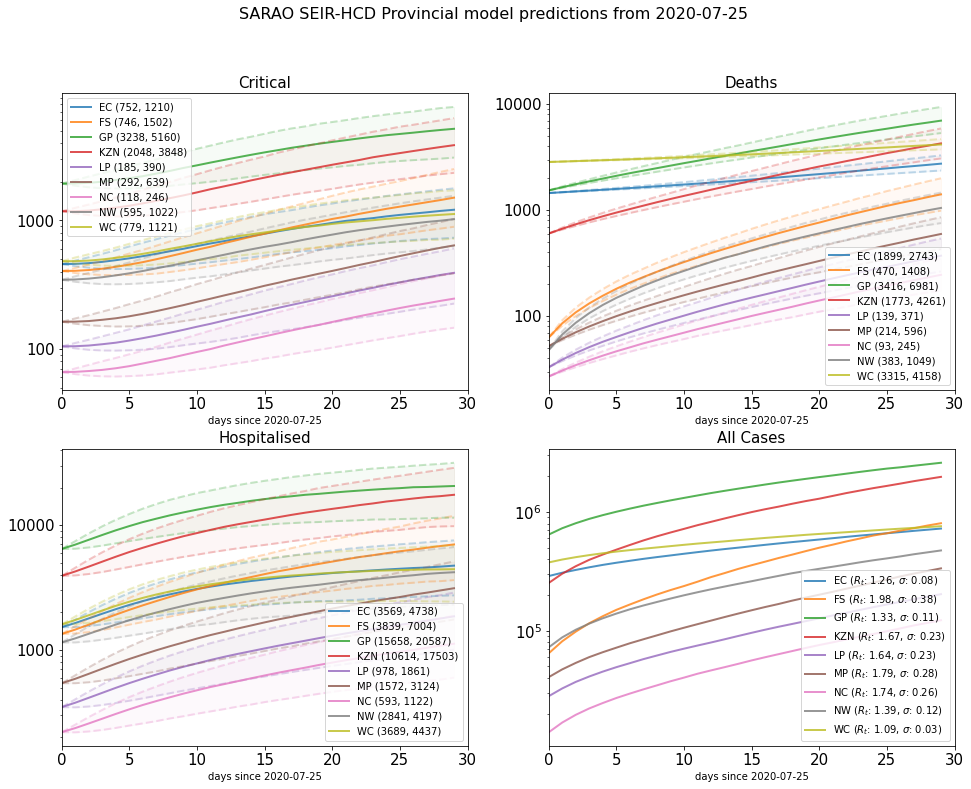

In [13]:
#print(len(scenarios), N, N_RUNS)
#plot_ensemble(N, p_scenarios.pop(), np.maximum(0.01, 50/N_RUNS), title = "SARAO: SEIR-HCD model - Intervention Scenario Ensemble")
#Recent_prov_Rt = {i: get_Rt_lm(SA_P_Con.tail(14)[i]) for i in SA_P_Con.columns}
#Recent_prov_Rt_inv = {v: k for k, v in Recent_prov_Rt.items()}
#Recent_prov_Rt_df = pd.DataFrame.from_dict(Recent_prov_Rt, orient='index', columns=['Median_Rt_estimate', 'error'])
#Recent_prov_Rt_new = Update_Rt(SA_P_Con.tail(14))
#Recent_prov_Rt, Recent_prov_Rt_df, Recent_prov_Rt_new

Recent_prov_Rt = Update_Rt(SA_P_Con.tail(14))

plot_medians(p_scenarios, Recent_prov_Rt)

Figure 1: _An ensemble of epidemic scenarios on a provincial level, run starting from this report's date. An exponential function is fit to the previous two week's (from the report date) recorded cases to derive $R_t$, which is then varied within the standard deviation of the fit over 1000 scenarios. In each of the figures, the y-axis indicates the number of people in each epidemiological state (Top-left: ICU, Top-right: deaths, Bottom-Left: hospitalisations, Bottom-Right: Total Cases). Solid lines indicate the median value of all the simulations, and the 68th percentiles are shown shaded between dashed lines. Total cases includes all cases, not just those testing positive; i.e. it includes asymptomatic, symptomatic, tested and untested cases, as well as recovered and deceased._

_The median values of our predictions at 14 and 30 days respectively are shown in parentheses following the province name in the legend, except for the bottom-right panel, which shows the $R_t$ value (and s.d.) fit to recorded cases (from [https://github.com/dsfsi/covid19za](https://github.com/dsfsi/covid19za)) over the previous two weeks._ 



## Provincial SEIR-HCD Model

An individual SEIR-HCD model is instantiated per province with current reported data, and an ensemble of 1000 models is run for 30 days from this report's date. For details and an extended explanation of the base model, please see our [National Model Report](https://docs.google.com/document/d/1WBri6wTXfwqwz4K18Yvt2vRan-ydz18RwgGZJLJHuLg).

In the provincial model shown in the figures above and the table below, the numbers given for each compartment will reflect the predicted number of individuals reported in the corresponding epidemiological state. 

In [14]:
%%capture my_tab_1

print('| Province | population | $R_t$ ($\sigma$) | Hosp. / ICU at day 14 | Hosp. / ICU at day 30 |')
fmt_string = '| Province | population | $R_t$ ($\sigma$) | Hosp. / ICU at day 14 | Hosp. / ICU at day 30 |'
print('| --- | --- | --- | --- | --- |')
fmt_string = fmt_string + '\n ' + '| --- | --- | --- | --- | --- |'

hosp_14 = {}
deaths_14 = {}

for p_idx, [scenarios, prov_long] in enumerate(p_scenarios):
  prov_pop_index = SA_P_Pop[SA_P_Pop['Province']==prov_long].index.item()
  prov_pop = SA_P_Pop.Pop[prov_pop_index]

  death_list = []
  hosp_list = []
  critical_list = []
  cases_list = []

  for idx, solution in enumerate(scenarios):
    sus, exp, inf, rec, hosp, crit, death = solution.y
    cases = (inf + rec + hosp + crit + death)
    death_list.append(death * prov_pop)
    hosp_list.append(hosp * prov_pop)
    critical_list.append(crit * prov_pop)
    cases_list.append(cases * prov_pop)
  
  median_curve_critical = np.percentile(critical_list, 50, axis = 0)
  median_curve_death = np.percentile(death_list, 50, axis = 0)
  median_curve_hosp = np.percentile(hosp_list, 50, axis = 0)
  median_curve_cases = np.percentile(cases_list, 50, axis = 0)

  # dictionary of number of hospitalisations at day 29 (to use later)
  hosp_14[prov_short_l[p_idx]]= int(np.median(hosp_list, axis=0)[14])
  deaths_14[prov_short_l[p_idx]]= int(np.median(death_list, axis=0)[14])

  plt.plot(median_curve_death, label=prov_long + " ($R_t$: " + "{:.1f}".format(Recent_prov_Rt[prov_short_l[p_idx]][0]) + ")") #semilogy()
  plt.legend()
  fmt_string = fmt_string + '\n ' + '|' + prov_long+ '|'+ str(prov_pop)+ '|'+  "{:.2f}".format(Recent_prov_Rt[prov_short_l[p_idx]][0])+ ' (' + "{:.2f}".format(Recent_prov_Rt[prov_short_l[p_idx]][1])+ ')' + '|' + str(int(median_curve_hosp[14]))+ ' / '+ str(int(median_curve_critical[14]))+ ' |'+ str(int(median_curve_hosp[29]))+ ' / '+ str(int(median_curve_critical[29]))+ ' |'
  print('|', prov_long, '|', prov_pop, '|',  "{:.2f}".format(Recent_prov_Rt[prov_short_l[p_idx]][0]), '|', int(median_curve_hosp[14]), ' (', int(median_curve_critical[14]), ') |', int(median_curve_hosp[29]), ' (', int(median_curve_critical[29]), ') |')
 

In [15]:
# sort the dictionary based on the value of predicted hospitalisations at day 30
sorted_hosp_14 = sorted(hosp_14.items(), key=lambda x: x[1], reverse=True)
# sort the dictionary based on the value of predicted hospitalisations at day 30
sorted_deaths_14 = sorted(deaths_14.items(), key=lambda x: x[1], reverse=True)

prov_long_l_s = []
prov_short_l_s = []
for prov in sorted_hosp_14:
  #if prov[1] > 300:
  prov_long_l_s.append(prov_dict[prov[0]])
  prov_short_l_s.append(prov[0])

#prov_long_l_s, prov_short_l_s, 

max_hosp = sorted_hosp_14[0]
#max_hosp, max_hosp[0], max_hosp[1]

In [16]:
#np.array(p_scenarios[prov_short_l.index(sorted_hosp_30[2][0])][0])
#np.empty((2,2))
#my_tab_1.show()

#p_scenarios[prov_short_l.index(sorted_hosp_30[2][0])][0]

In [17]:
%%capture my_tab_2
fmt_string = '| Province | population | $R_t$ ($\sigma$) | Hosp. / Crit. at day 14 | Hosp. / Crit. at day 30 | Provincial hosp. ratio'
fmt_string = fmt_string + '\n ' + '| --- | --- | --- | --- | --- | ---'

for p_idx, prov_long in enumerate(prov_long_l_s):
  scenarios = p_scenarios[prov_long_l.index(prov_long)][0]
  prov_pop_index = SA_P_Pop[SA_P_Pop['Province']==prov_long].index.item()
  prov_pop = SA_P_Pop.Pop[prov_pop_index]

  death_list = []
  hosp_list = []
  critical_list = []
  cases_list = []

  for idx, solution in enumerate(scenarios):
    sus, exp, inf, rec, hosp, crit, death = solution.y
    cases = (inf + rec + hosp + crit + death)
    death_list.append(death * prov_pop)
    hosp_list.append(hosp * prov_pop)
    critical_list.append(crit * prov_pop)
    cases_list.append(cases * prov_pop)
  
  median_curve_critical = np.percentile(critical_list, 50, axis = 0)
  median_curve_death = np.percentile(death_list, 50, axis = 0)
  median_curve_hosp = np.percentile(hosp_list, 50, axis = 0)
  median_curve_cases = np.percentile(cases_list, 50, axis = 0)

  # dictionary of number of hospitalisations at day 29 (to use later)
  hosp_14[prov_short_l[p_idx]]= int(np.median(hosp_list, axis=0)[14])
  deaths_14[prov_short_l[p_idx]]= int(np.median(death_list, axis=0)[14])

  plt.semilogy(median_curve_death, label=prov_long + " ($R_t$: " + "{:.1f}".format(Recent_prov_Rt[prov_short_l_s[p_idx]][0]) + ")") #semilogy()
  plt.legend()
  fmt_string = fmt_string + '\n ' + '|' + prov_long+ '|'+ str(prov_pop)+ '|'+  "{:.2f}".format(Recent_prov_Rt[prov_short_l_s[p_idx]][0])+ ' (' + "{:.2f}".format(Recent_prov_Rt[prov_short_l_s[p_idx]][1])+ ')' + '|' + str(int(median_curve_hosp[14]))+ ' / '+ str(int(median_curve_critical[14])) + ' |'+ str(int(median_curve_hosp[29]))+ ' / '+ str(int(median_curve_critical[29])) + ' | ' + "{:.2f}".format(median_curve_hosp[14]/max_hosp[1]) + ' |'
  


In [18]:
display(Markdown(fmt_string))

| Province | population | $R_t$ ($\sigma$) | Hosp. / Crit. at day 14 | Hosp. / Crit. at day 30 | Provincial hosp. ratio
 | --- | --- | --- | --- | --- | ---
 |Gauteng|15176115|1.33 (0.11)|15658 / 3238 |20587 / 5160 | 1.00 |
 |KwaZulu-Natal|11289086|1.67 (0.23)|10614 / 2048 |17503 / 3848 | 0.68 |
 |Free State|2887465|1.98 (0.38)|3839 / 746 |7004 / 1502 | 0.25 |
 |Western Cape|6844272|1.09 (0.03)|3689 / 779 |4437 / 1121 | 0.24 |
 |Eastern Cape|6712276|1.26 (0.08)|3569 / 752 |4738 / 1210 | 0.23 |
 |Northwest|4027160|1.39 (0.12)|2841 / 595 |4197 / 1022 | 0.18 |
 |Mpumalanga|4592187|1.79 (0.28)|1572 / 292 |3124 / 639 | 0.10 |
 |Limpopo|5982584|1.64 (0.23)|978 / 185 |1861 / 390 | 0.06 |
 |Northern Cape|1263875|1.74 (0.26)|593 / 118 |1122 / 246 | 0.04 |

Table 1: _Key provincial predictions. The current value of $R_t$ per province is calculated from recorded cases over the previous 14 days using an exponential fit. This value of $R_t$ is allowed to vary within the standard deviation of this fit for 1000 ensemble runs. Both $R_t$ and its standard deviation are tabled. Median predictions for hospitalisation / critical compartment numbers are tabled for 14 and 30 days, as well as the relative ratio of predicted hospitalisations at day 14._

_Provincial populations and cases are from [https://github.com/dsfsi/covid19za](https://github.com/dsfsi/covid19za)._

## Recorded Deaths 

The following two figures show, for reference, the recorded deaths in each province on a logarithmic and a linear scale respectively since 1 April 2020 (from [https://github.com/dsfsi/covid19za](https://github.com/dsfsi/covid19za)).

In [19]:
#SA_P_Dead.plot(logy=True), SA_P_Dead.plot()
#fig = plt.gcf()
#fig.suptitle("SA Provincial recorded deaths", fontsize=14)
#plt.show()

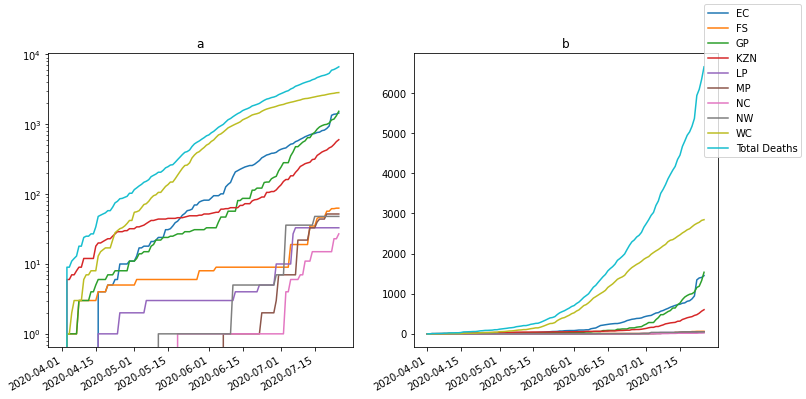

In [20]:
prov_short_l = ['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']
prov_short_l.append('Total Deaths')
fig, ax = plt.subplots(1,2, figsize=(12,6))
for i in prov_short_l:
  ax[0].semilogy(SA_P_Dead[i].index, SA_P_Dead[i], label=i)

ax[1].plot(SA_P_Dead.index, SA_P_Dead)

ax[0].set_title('a')
ax[1].set_title('b')
fig.autofmt_xdate()
fig.legend()

prov_short_l = ['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

Figure 2: _Recorded deaths per province on a (a) logarithmic, and (b) linear scale since 1 April 2020 (from [https://github.com/dsfsi/covid19za](https://github.com/dsfsi/covid19za))_

__

In [36]:
#print()
#print(prov_short_l)
#SA_P_Dead.tail(7)
#Table 3: _Confirmed COVID-19 cases per province for the last 7 days (from [https://github.com/dsfsi/covid19za](https://github.com/dsfsi/covid19za))_

#fig, ax = plt.subplots(1,1)
#ax.bar(SA_P_Dead.index[:-1], np.diff(SA_P_Dead['WC']), color=np.random.rand(3,))
#fig.autofmt_xdate()

In [22]:
#np.max(np.diff(SA_P_Dead['WC']))
#np.max([[2,6,9],[8,7,12]])

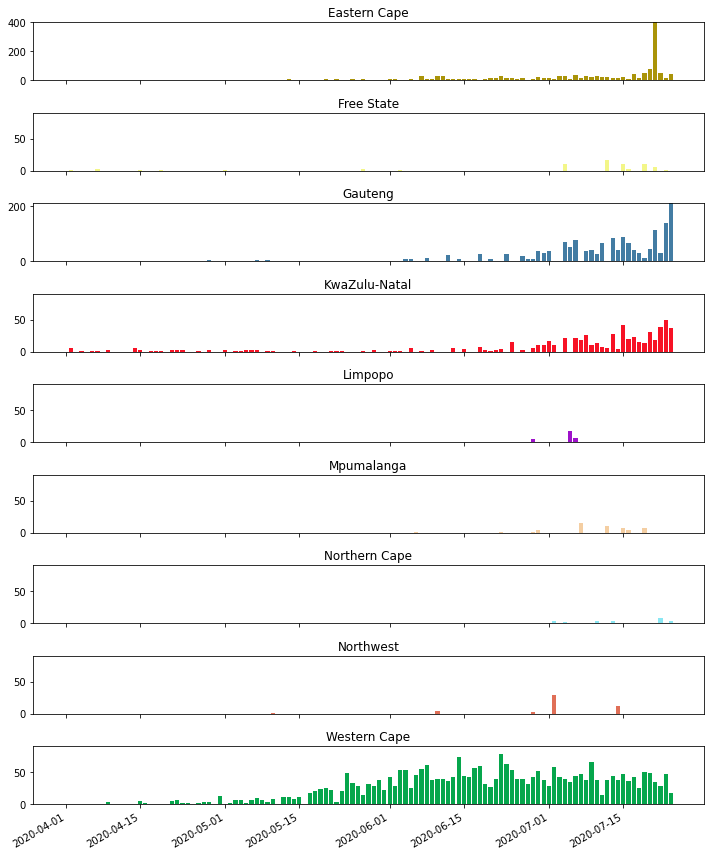

In [23]:
#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(12,12))
fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9)) = plt.subplots(9,1, figsize=(10,12))
for idx, axis in enumerate([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]):
  axis.set_title(prov_long_l[idx])
  axis.set_ylim(0, np.maximum(90, np.max(np.diff(SA_P_Dead[prov_short_l[idx]]))))
  axis.bar(SA_P_Dead.index[:-1], np.diff(SA_P_Dead[prov_short_l[idx]]), color=np.random.rand(3,))#, label = prov_short_l[idx])

#fig.suptitle("Daily deaths per province since 1 April 2020")
fig.autofmt_xdate()
fig.tight_layout()
fig.show()

Figure 3: _Daily recorded deaths per province since 1 April 2020._

## Histograms 


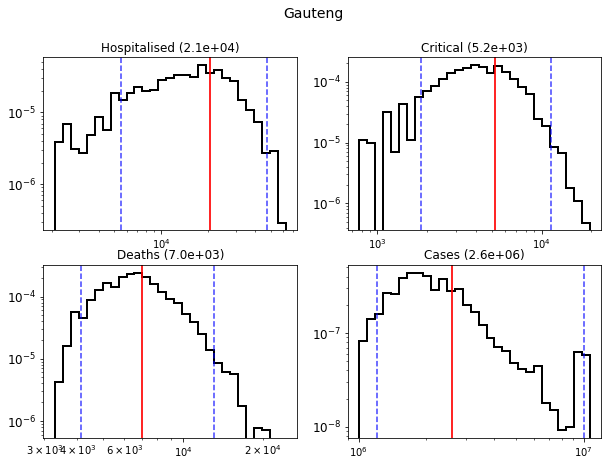

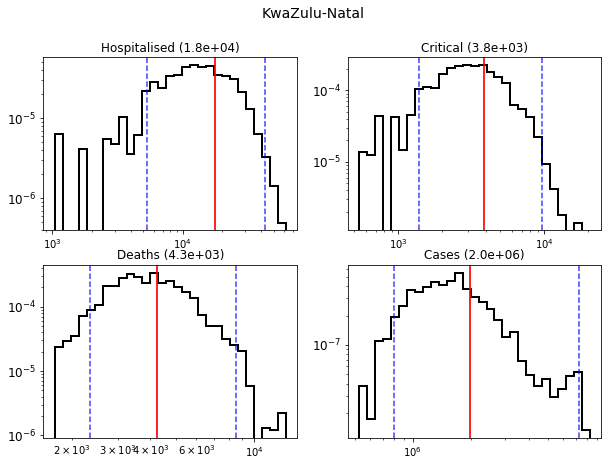

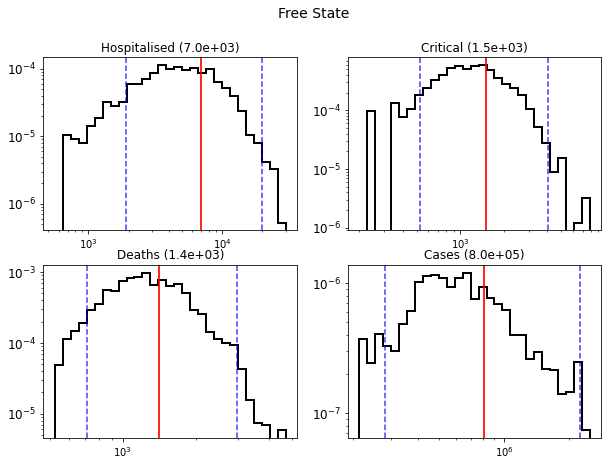

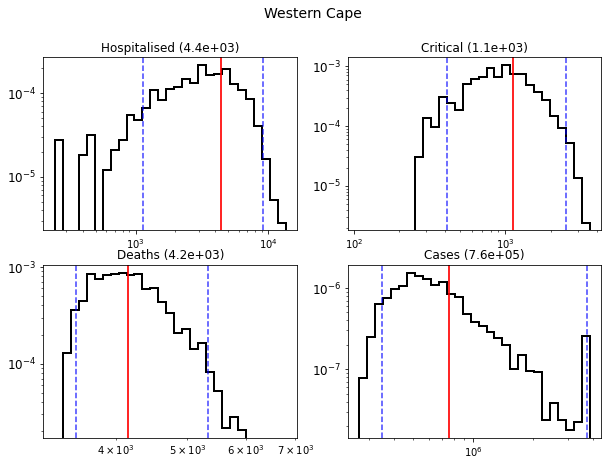

In [24]:
eval_day = 29

# plot histograms of the top 3 provinces on the hospitalisations at day 30 metric
for i in range(4):
  curr_prov_name = sorted_hosp_14[i][0]
  curr_scenarios = p_scenarios[prov_short_l.index(curr_prov_name)][0]
  prov_pop_index = SA_P_Pop[SA_P_Pop['Province']==prov_dict[curr_prov_name]].index.item()
  prov_pop = SA_P_Pop.Pop[prov_pop_index]

  deaths_arr = np.empty((N_RUNS, model_days))
  hosp_arr = np.empty((N_RUNS, model_days))
  critical_arr = np.empty((N_RUNS, model_days))
  cases_arr = np.empty((N_RUNS, model_days))

  for idx, solution in enumerate(curr_scenarios):
    sus, exp, inf, rec, hosp, crit, death = solution.y
    cases = (inf + rec + hosp + crit + death)
    deaths_arr[idx, :] = death * prov_pop
    hosp_arr[idx, :] = hosp * prov_pop
    critical_arr[idx, :] = crit * prov_pop
    cases_arr[idx, :] = cases * prov_pop

  compartment_labels = ['Susceptible', 'Exposed', 'Infectious', 'Recovered', 'Hospitalised', 'Critical', 'Deaths']
  show_labels = ['Hospitalised', 'Critical', 'Deaths', 'Cases']
  show_arr = np.array((hosp_arr, critical_arr, deaths_arr, cases_arr)) # an ordered array for the four quadrants of histograms
  #print(show_arr.shape)

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,7))
  fig.suptitle(prov_dict[sorted_hosp_14[i][0]], fontsize=14)
  #plt.tight_layout()

  for idx, axis in enumerate([ax1, ax2, ax3, ax4]):
    hist_data = show_arr[idx, :, eval_day]
    MAX=np.max(hist_data)
    MIN=np.min(hist_data)
    bins = np.logspace(np.log10(MIN), np.log10(MAX), 30)
    #bins = np.linspace(MIN, MAX, 30)

    axis.set_title(show_labels[idx] + ' (' + "{:.1e}".format(np.percentile(hist_data, 50)) + ')')
    axis.set_yscale('log')
    axis.set_xscale('log')
    axis.tick_params(axis='y', labelsize=12);

    axis.hist(hist_data, bins=bins, density=True, histtype='step', color = 'k', linewidth = '2')

    #percentiles
    axis.axvline(np.percentile(hist_data, 50), color='red', linewidth = '2', linestyle='solid', alpha=0.85) #ax2.axvline(np.median(h_data), color='g')
    #axis.axvline(np.median(hist_data), color='g')
    #axis.axvline(np.percentile(hist_data, 84), color='blue', linestyle='dashed', alpha=0.5)
    #axis.axvline(np.percentile(hist_data, 16), color='red', linestyle='dashed', alpha=0.5)
    axis.axvline(np.percentile(hist_data, 97.5), color='blue', linestyle='dashed', alpha=0.75)
    axis.axvline(np.percentile(hist_data, 2.5), color='blue', linestyle='dashed', alpha=0.75)

Figure 4: _Histograms through the ensembles at day 30 of predicted concurrent hospitalised individuals, critical individuals, predicted deaths, and total cases respectively from left to right and top to bottom for each of the top four provinces ranked by number of hospitalisations at day 14. Vertical lines are 2.5th (blue dotted, left), 50th (median, red solid), and 97.5th percentiles (blue dotted, right)._

## Model Verification


In [25]:
# how to do model verification?
# run the ensemble with a start date of 14 days previous
%%capture mv
two_weeks_ago = date.today() - timedelta(days=15)
v_start_date = str(two_weeks_ago)

model_days = 15

SA_P_Con, SA_P_Dead, SA_P_Rec, SA_P_Pop = get_SA_province('y') #use 'y' if no local datasets stored

# rename Dead to Total Deaths, and drop the UNKNOWN col
for idx, SA_P in enumerate([SA_P_Con, SA_P_Dead, SA_P_Rec]):
  SA_P.rename(columns={'Dead':'Total Deaths'}, inplace=True)
  SA_P.rename(columns={'Confirmed':'Total Confirmed'}, inplace=True)
  SA_P.drop(columns={'UNKNOWN'}, inplace=True)

Historical_prov_Rt = Update_Rt(SA_P_Con.tail(28).head(14)) # old: {i: get_Rt_lm(SA_P_Con.tail(28).head(14)[i]) for i in SA_P_Con.columns}

t_1 = 0
t_2 = 30

h_scenarios = []

for p_idx, prov_long in enumerate(prov_long_l_s):
    prov_pop_index = SA_P_Pop[SA_P_Pop['Province']==prov_long].index.item()
    ## Pull out population for specified province
    prov_pop = SA_P_Pop.Pop[prov_pop_index]
    ## get confirmed cases at date for province specified
    prov_con = SA_P_Con.loc[v_start_date, prov_short_l_s[p_idx]]
    ## get recovered cases at date for province specified
    prov_rec = SA_P_Rec.loc[v_start_date, prov_short_l_s[p_idx]]
    ## get deaths at date for province specified
    prov_dead = SA_P_Dead.loc[v_start_date, prov_short_l_s[p_idx]]
    
    N = prov_pop  # Population size
    n_total_cases = prov_con 
    n_recovered = prov_rec
    n_tested_active =  prov_con - prov_rec # total cases - recovered: 
    n_hosp = 0.1* n_tested_active #making an estimate - there is real data from here for WC https://corona-stats.mobi/en/ZA/westerncape.php
    n_crit = 0.3* n_hosp ##making an estimate - there is real data from here for WC https://corona-stats.mobi/en/ZA/westerncape.php
    n_dead = prov_dead
    
    
    scenarios = []
    
    for i in range(N_RUNS):
        R_t_1 = np.maximum(0.9, np.random.normal(Historical_prov_Rt[prov_short_l_s[p_idx]][0], 0.15))
        R_t_2 = np.maximum(0.9, np.random.normal(Historical_prov_Rt[prov_short_l_s[p_idx]][0], 0.25))

        # Draw from epidemiological parameter distributions
        R_0 = np.maximum(1.0, np.random.normal(1.35, 0.15))
        t_incu = np.random.normal(5.1, 0.325) # average incubation period: "median incubation period was estimated to be 5.1 days (95% CI, 4.5 to 5.8 days) https://www.acpjournals.org/doi/10.7326/M20-0504
        t_infect = np.maximum(2, np.random.normal(9.3, 1.15)) #t_infect = np.maximum(3,np.random.normal(9.3, 1.15)) NB - changed to range over which density of infectiousness was 1%
        t_hosp = np.maximum(3, np.random.normal(10.4, 4)) # time in hospital before transitioning to either critical or recovered https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf
        t_crit = np.maximum(3, np.random.normal(10, 2)) # average time patient is critical before transition to recovered or dead    https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf

        frac_asymptomatic = np.minimum(0.96, np.random.normal(0.75, 0.15)) #5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
        frac_tested_mild = np.minimum(0.96, np.random.normal(0.85, 0.05)) # ratio of tested infections that are mild. [CCDC]
        frac_mild_total = 1-((1-frac_asymptomatic) * (1 - frac_tested_mild))
        
        frac_crit = np.maximum(0.17, np.random.normal(0.31, 0.07)) # fraction of severe cases that become critical: 33% died, 49% discharged, 17% continue receiveing care, 17% required ICU: 45% died, 31% discharged 
        frac_fatal = np.maximum(0.2, np.random.normal(0.56, 0.06))  # fraction of critical cases that result in death: https://www.medrxiv.org/content/10.1101/2020.04.23.20076042v1.full.pdf
        
        n_infected = n_tested_active * (1/(1-frac_asymptomatic))
        n_exposed = n_infected * 1.7 #(R_t^(time from infection to test)/t_inf ~ 2)*n_infected
        n_recovered = (n_total_cases - n_tested_active) * (1/(1-frac_asymptomatic))

        n_susceptible = N - (n_exposed + n_infected + n_recovered + n_hosp + n_crit + n_dead)
        
        # Set up state and solve IVP

        initial_state = [n_susceptible/N, n_exposed/N, n_infected/N, n_recovered/N, n_hosp/N, n_crit/N, n_dead/N] #S, E, I, R, H, C, D  
        
        args = (time_varying_reproduction, t_incu, t_infect, t_hosp, t_crit, frac_mild_total, frac_crit, frac_fatal)
        
        sol = solve_ivp(SEIR_HCD_model, [0, model_days], initial_state, args=args, t_eval=np.arange(model_days))
        
        scenarios.append(sol)

    #plot_ensemble(N, scenarios, 0.05, title = "SARAO: SEIR-HCD model - Intervention Scenario Ensemble")

    h_scenarios.append([scenarios, prov_long])

In [93]:
%%capture mv_tab

print('| Province | $R_t (\sigma)$ on ', two_weeks_ago, '| Deaths on ', two_weeks_ago, ' | Prediction ', start_date, ' | Recorded on ', start_date, '| $\Delta$ (%) |')
print('| --- | --- | --- | --- | --- | --- |  ')
fmt_string = '| Province | $R_t (\sigma)$ on ' + str(two_weeks_ago) + '| Deaths on '+ str(two_weeks_ago)+ '| Prediction (std. err.) for ' + start_date + ' | Recorded on '+ start_date + ' | '#$\Delta (\sigma$) |'
fmt_string = fmt_string + '\n ' + '| --- | --- | --- | --- | --- | '# --- |'

for p_idx, [scenarios, prov_long] in enumerate(h_scenarios):
  prov_pop_index = SA_P_Pop[SA_P_Pop['Province']==prov_long].index.item()
  prov_pop = SA_P_Pop.Pop[prov_pop_index]

  death_list = []
  hosp_list = []
  critical_list = []
  cases_list = []

  for idx, solution in enumerate(scenarios):
    sus, exp, inf, rec, hosp, crit, death = solution.y
    cases = (inf + rec + hosp + crit + death)
    death_list.append(death * prov_pop)
    hosp_list.append(hosp * prov_pop)
    critical_list.append(crit * prov_pop)
    cases_list.append(cases * prov_pop)
  
  median_curve_critical = np.percentile(critical_list, 50, axis = 0)
  median_curve_death = np.percentile(death_list, 50, axis = 0)
  std_upp_curve_death = np.percentile(death_list, 84, axis = 0)
  std_low_curve_death = np.percentile(death_list, 16, axis = 0)
  median_curve_hosp = np.percentile(hosp_list, 50, axis = 0)
  median_curve_cases = np.percentile(cases_list, 50, axis = 0)
  
  plt.plot(median_curve_death, label=prov_long + " ($R_t$: " + "{:.2f}".format(Historical_prov_Rt[prov_short_l_s[p_idx]][0]) + ")") #semilogy()
  plt.legend()

  std_err = (int(std_upp_curve_death[13]) - int(std_low_curve_death[13]))/2
  err_sig = (SA_P_Dead[prov_short_l_s[p_idx]][start_date] - int(median_curve_death[13]))/std_err

  print('|', prov_long, '|',  "{:.2f}".format(Historical_prov_Rt[prov_short_l_s[p_idx]][0]), '|', int(SA_P_Dead[prov_short_l_s[p_idx]][two_weeks_ago]), ' |', int(median_curve_death[13]), '|', int(SA_P_Dead[prov_short_l_s[p_idx]][start_date]), ' |', "{:.2f}".format(100*(SA_P_Dead[prov_short_l_s[p_idx]][start_date] - int(median_curve_death[13]))/int(median_curve_death[13])), '|')
  fmt_string = fmt_string + '\n ' + '|'+ prov_long+ '|'+  "{:.2f}".format(Historical_prov_Rt[prov_short_l_s[p_idx]][0])+ ' ('+"{:.2f}".format(Historical_prov_Rt[prov_short_l_s[p_idx]][1])+')'+'|'+ str(int(SA_P_Dead[prov_short_l_s[p_idx]][two_weeks_ago]))+ ' |'+ str(int(median_curve_death[13])) +' ('+ str(int(std_err)) + ')|'+ str(int(SA_P_Dead[prov_short_l_s[p_idx]][start_date])) + ' |' #+ "{:.1f}".format(err_sig) + '|'

In [94]:
display(Markdown(fmt_string))

| Province | $R_t (\sigma)$ on 2020-07-11| Deaths on 2020-07-11| Prediction (std. err.) for 2020-07-25 | Recorded on 2020-07-25 | 
 | --- | --- | --- | --- | --- | 
 |Gauteng|1.76 (0.29)|580 |2322 (488)|1535 |
 |KwaZulu-Natal|1.88 (0.35)|273 |760 (135)|602 |
 |Free State|2.25 (0.54)|19 |127 (32)|63 |
 |Western Cape|1.17 (0.05)|2333 |2870 (144)|2845 |
 |Eastern Cape|1.52 (0.18)|664 |1136 (134)|1450 |
 |Northwest|1.81 (0.30)|36 |244 (60)|48 |
 |Mpumalanga|2.26 (0.51)|22 |97 (23)|52 |
 |Limpopo|2.02 (0.36)|33 |83 (15)|33 |
 |Northern Cape|2.11 (0.44)|11 |37 (8)|27 |

Table 2: _Model Verification: median model predictions (std. err.) for today's date calculated from data 14 days ago compared to reported provincial deaths. The columns show, respectively, the province name, the historical $R_t (\sigma)$ from two weeks ago, recorded deaths on that date, the model prediction, recorded deaths at the prediction date, and the percentage error._

In [ ]:
#_Any recorded value that is chosen for verification is subject to systemic errors: recorded cases are subject to the nonlinear effects of testing, hospitalisation to heterogenous access to facility, and deaths to underreporting (for e.g. [excess mortality link]()) _

In [28]:
#plot_medians(h_scenarios, Historical_prov_Rt)
#start_date = str(yesterday)
#SA_P_Dead['EC'][start_date]
#print('--')#'\pagebreak')
#mv_tab.show()



# National Model

Shown below for reference are the predictions of the [SARAO NVP National Model ensembles](https://docs.google.com/document/d/1WBri6wTXfwqwz4K18Yvt2vRan-ydz18RwgGZJLJHuLg).

The figure below shows a full ensemble of 2000 epidemic runs starting on 1 April 2020 (Day 0). On the y-axis we plot the number of people in each state (Top-left: ICU, Top-right: deaths, Bottom-Left: hospitalisations, Bottom-Right:Total Cases). 

Our models have peaks that vary by up to about 100 days. Magenta lines indicate the median value of all the simulations. Models with average Rt > 2 imply more than 80% of the population get infected. The black line on the fatalities curve shows actual South African deaths. Note that most of our models struggle to match observed deaths to the current time, suggesting that we may be underestimating the fatality rate.




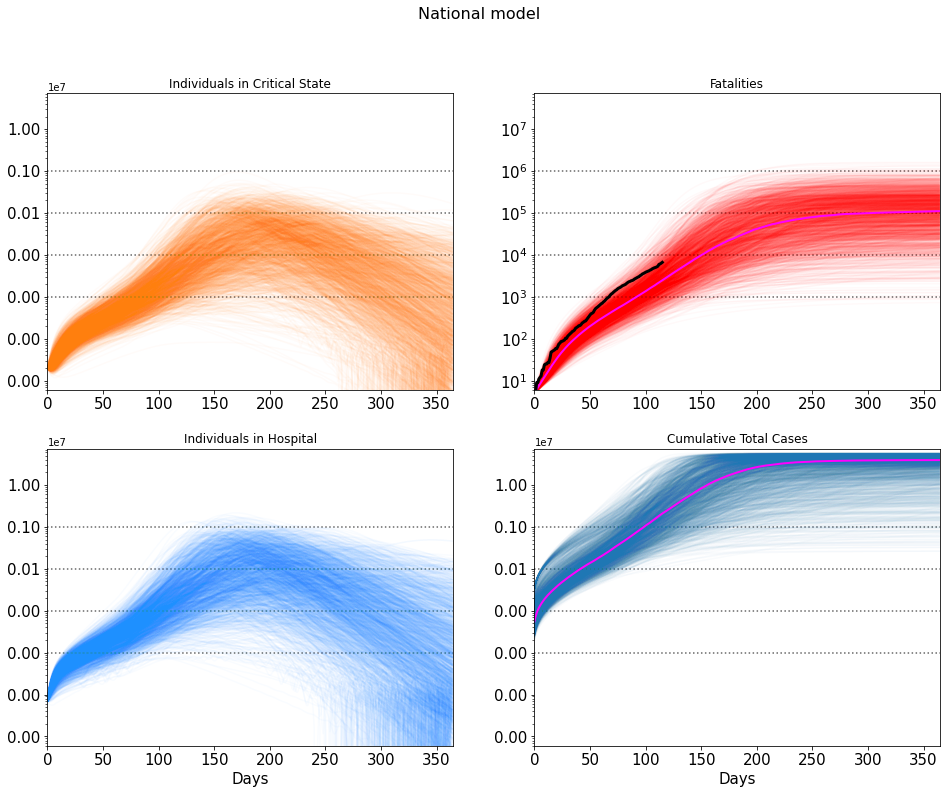

In [35]:
# Note: taken from Final_COVID-19 SARAO_Bounding_Epidemiological_Model_0.5.ipynb
# Reported values for South Africa on April 1

N = 59156682  # Population size
n_tested_active =  1325 
n_total_cases = 1380 
n_hosp = 70 
n_crit = 20 
n_dead = 5 

def time_varying_reproduction(t):
  if t <= t_1:
    # throw warning that default value of R_0 is being used
    warnings.warn("Using lower default R_0 in time-varying_reproduction function") 
    return R_0
  elif t > t_1 and t <= t_2:
    return R_t_1
  elif t > t_2 and t <= t_3:
    return R_t_2
  elif t > t_3 and t <= t_4:
    return R_t_3
  elif t > t_4 and t <= t_5:
    return R_t_4
  elif t > t_5:
    return R_t_5
  else:
    warnings.warn("Using upper default R_0 in time-varying_reproduction function")
    return R_0

model_days = 365  
N_RUNS = 2000
t_arr = np.empty((N_RUNS, model_days))
low_dead = 0
i_scenarios = []
ifr_list = []
R_0_list = []
attack_list = []
ifr_max = 10
ifr_min = 0.0

for i in range(N_RUNS):
  #if i%200 == 199: 
    #print('Reached run: ', i+1)

  # 'Scenario' parameters: draw from distributions of plausible values for R_t as well as the dates on which interventions will be enacted
  
  R_t_1 = np.maximum(1.25,np.random.normal(1.45, 0.15))
  R_t_2 = np.maximum(0.85, R_t_1*np.random.normal(1.20, 0.15))
  R_t_3 = np.maximum(0.65, R_t_2*np.random.normal(1.00, 0.20))
  R_t_4 = np.maximum(0.65, R_t_3*np.random.normal(1.00, 0.20))
  R_t_5 = np.maximum(0.65, R_t_4*np.random.normal(0.85, 0.30))

  t_1 = -1
  t_2 = int(np.maximum(31, np.random.normal(60, 7)))
  t_3 = int(np.maximum(61, np.random.normal(90, 7)))
  t_4 = int(np.random.normal(150, 21))
  t_5 = int(np.random.normal(183, 28))

  # Epidemiological parameters
  R_0 = np.random.normal(2.7, 0.35)
  t_incu = np.random.normal(5.1, 0.325) # average incubation period: "median incubation period was estimated to be 5.1 days (95% CI, 4.5 to 5.8 days) https://www.acpjournals.org/doi/10.7326/M20-0504
  # "The mean incubation period was 5.2 days (95% confidence interval [CI], 4.1 to 7.0), with the 95th percentile of the distribution at 12.5 days." https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
  t_infect = np.maximum(2, np.random.normal(9.3, 1.15)) # average infectious period  https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30196-1/fulltext  # also see https://theconversation.com/how-long-are-you-infectious-when-you-have-coronavirus-135295
  # 2.3 days (95% CI, 0.8–3.0 days) before symptom onset and peaked at 0.7 days (95% CI, −0.2–2.0 days) before symptom onset (Fig. 1c). The estimated proportion of presymptomatic transmission (area under the curve) was 44% (95% CI, 25–69%). Infectiousness was estimated to decline quickly within 7 days. https://www.nature.com/articles/s41591-020-0869-5
  t_hosp = np.maximum(3, np.random.normal(10.4, 4)) # time in hospital before transitioning to either critical or recovered https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf
  t_crit = np.maximum(3, np.random.normal(10, 2)) # average time patient is critical before transition to recovered or dead    https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf

  frac_asymptomatic = np.minimum(0.96, np.random.normal(0.75, 0.15)) #5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
  frac_tested_mild = np.minimum(0.96, np.random.normal(0.8, 0.05)) # ratio of tested infections that are mild. [CCDC]
  frac_mild_total = 1-((1-frac_asymptomatic) * (1 - frac_tested_mild))

  # e.g. https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30196-1/fulltext 
  # https://www.medrxiv.org/content/10.1101/2020.04.23.20076042v1.full.pdf: 

  frac_crit = np.maximum(0.17, np.random.normal(0.25, 0.1)) # fraction of severe cases that become critical
  # Note: in our model, all those who die must go through the critical compartment first. Thus, frac_crit and frac_fatal might be larger than values read from hospital->ICU and ICU->death records. A reminder that Critical, Hospitalised, etc are states of being, and need not exactly align to the location of an individual. For instance, individuals may move through Hospitalised and Critical compartments before eventually dying, all while still at home. 
  
  frac_fatal = np.maximum(0.2, np.random.normal(0.30, 0.1))  
  
  n_infected = n_tested_active * (1/(1-frac_asymptomatic)) # true infections from known tested positive
  n_exposed = n_infected * 1.7

  # model an immune fraction
  frac_immune = np.minimum(0.5, np.random.uniform(0., 0.3))

  n_susceptible = (N - (n_exposed + n_infected + n_recovered + n_hosp + n_crit + n_dead))#*(1-frac_immune) # model a variable% immune fraction

  n_recovered = (n_total_cases - n_tested_active) * (1/(1-frac_asymptomatic)) #+ n_susceptible*frac_immune

  initial_state = [n_susceptible/N, n_exposed/N, n_infected/N, n_recovered/N, n_hosp/N, n_crit/N, n_dead/N] #S, E, I, R, H, C, D  
  
  # Model a variable immune fraction: 
  # frac_immune = np.minimum(np.maximum(0.05, np.random.normal(0.2, 0.15)), 0.9)
  # initial_state = [(1-frac_immune)*(N-n_infected)/N, n_exposed/N, n_infected/N, ((frac_immune)*(N-n_infected-n_recovered))/N, n_hosp/N, n_crit/N, n_dead/N]

  args = (time_varying_reproduction, t_incu, t_infect, t_hosp, t_crit, frac_mild_total, frac_crit, frac_fatal)

  # run solver and save to solution nparray
  sol = solve_ivp(SEIR_HCD_model, [0, model_days], initial_state, args=args, t_eval=np.arange(model_days))
  total_cases = sol.y[2][-1] + sol.y[3][-1] + sol.y[4][-1] + sol.y[5][-1] + sol.y[6][-1]  
  ifr = 100*sol.y[6][-1]/total_cases 
  old_sol = sol

  if (ifr < ifr_max) & (ifr > ifr_min): 
    i_scenarios.append(sol)
    ifr_list.append(ifr)
  else:
    i_scenarios.append(old_sol)
  
  attack_list.append(sol.y[3][-1])
  R_0_list.append(R_0)

#########
  dn = np.linspace(1e+02, 5e+04, 100)
  rn = np.linspace(3, 1.2, 100)
  t = np.empty(model_days)
  for j in range(model_days):
      rtcap = rn[find_idx_nearest(dn, sol.y[6][j]*N)] 
      reprod = time_varying_reproduction(j)
      reprod = np.minimum(rtcap, reprod)
      t[j] = reprod

  #plt.plot(t, color='blue', alpha=0.045)
  #plt.ylabel("$R_t$", fontsize = 16)
  #plt.xlabel("Day (from 1 April 2020)", fontsize = 15)
  #plt.tick_params(axis='y', labelsize=15);
  #plt.tick_params(axis='x', labelsize=15);

  t_arr[i,:] = t

plot_ensemble(N, i_scenarios, 50/N_RUNS, title = "National model")



Figure 5: _The full ensemble of 2000 National Model epidemic runs starting on 1 April 2020 (Day 0). On the y-axis we plot the number of people in each state (Top-left: ICU, Top-right: deaths, Bottom-Left: hospitalisations, Bottom-Right:Total Cases). Note how the models have peaks that vary by up to about 100 days. Magenta lines indicate the median value of all the simulations. Note that models with average $R_t > 2$ typically imply more than 80% of the population get infected. The black line on the fatalities curve shows actual South African deaths. Note that most of our models struggle to match observed deaths suggesting that we may be underestimating the fatality rate. Total cases includes all cases, not just those testing positive; i.e. it includes asymptomatic, symptomatic, tested and untested cases, as well as recovered and deceased._

In [30]:
#model_days = 60
N_RUNS=1000